In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [27]:
df = pd.read_csv(r"D:\projects\web scraping\preprocess_data.csv")

In [28]:
df

,Product Name,Price,Rating,Number of Ratings,Number of Reviews,Review Summary,Review Details
0,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Mind-blowing purchase,Absolute gem
1,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Wonderful,Nice beast
2,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Awesome,"One word, Beast! But don't except much on batt..."
3,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Delightful,Awesome Laptop
4,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Absolute rubbish!,1 star rating is for Flipkart's smart upgrade ...
5,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Worth the money,Awesome product
6,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Did not meet expectations,The speaker 🔊 is not working
7,Lenovo Lenovo Legion Slim 5 AI Powered AMD Ryz...,"₹1,15,990",3.3,3,1,Terrific,Absolute gem
8,Lenovo Legion 5 AMD AMD Ryzen 7 Octa Core 5800...,"₹99,990",4.3,92,18,Good quality product,Nice beast
9,Lenovo Legion 5 AMD AMD Ryzen 7 Octa Core 5800...,"₹99,990",4.3,92,18,Highly recommended,"One word, Beast! But don't except much on batt..."


In [29]:
df['Rating'] = pd.to_numeric(df['Rating'])

In [32]:
def calculate_weighted_score(row, model):

    #Normalizing ratings
    normalized_rating = row['Rating']/5

    #Calculate sentiment scores for review summary and details
    review_summary_score = model(row['Review Summary'])
    review_details_score = model(row['Review Details'])

    #Review summary sentiment scores
    review_summary_negative_val = review_summary_score['neg']
    review_summary_neutral_val = review_summary_score['neu']
    review_summary_positive_val = review_summary_score['pos']
    review_summary_compound_val = review_summary_score['compound']

    #Review details sentiment scores
    review_details_negative_val = review_details_score['neg']
    review_details_neutral_val = review_details_score['neu']
    review_details_positive_val = review_details_score['pos']
    review_details_compound_val = review_details_score['compound']
    
    # print("Product Name: ", row["Product Name"])
    # print("Normalized Rating: ", normalized_rating)
    # print("Normalized number of reviews: ", normalized_rating)
    # print(row['Review Summary'])
    # print("Summary Review Score: ", review_summary_score)
    # print(row['Review Details'])
    # print("Summary Details Score: ", review_details_score)
    # print("-" *50)
    
    #Initializing weights based on imporance of features
    weights = {"Rating" : 0.2, "Review Summary" : 0.3, "Review Details" : 0.5}
    #Weighted score calculations
    weighted_negative_score = (review_summary_negative_val * weights["Review Summary"] + review_details_negative_val * weights["Review Details"])
    weighted_neutral_score = (review_summary_neutral_val * weights["Review Summary"] + review_details_neutral_val * weights["Review Details"])
    weighted_positive_score = (review_summary_positive_val * weights["Review Summary"] + review_details_positive_val * weights["Review Details"])
    
    weighted_compound_score = (normalized_rating * weights["Rating"] +
                      review_summary_compound_val * weights["Review Summary"] +
                      review_details_compound_val * weights["Review Details"])
    
    return weighted_negative_score, weighted_neutral_score, weighted_positive_score, weighted_compound_score


## VADER Sentiment Analysis

In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [34]:
#Loading the VADER model
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The laptop is really good and has a lot of cool and latest features")

{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'compound': 0.6697}

In [35]:
print(df['Review Details'][1])
sia.polarity_scores(df['Review Details'][1])

Nice beast


{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}

In [36]:
#Calculates the VADER score for some 'text'
def calculate_vader_score (text):
    return sia.polarity_scores(text)

In [37]:
#Run the polarity score on the entire dataset and create columns for it
df[['VADER_neg','VADER_neu','VADER_pos','VADER_compound_score']] = df.apply(calculate_weighted_score, args=(calculate_vader_score,), axis = 1,result_type='expand')

In [38]:
df.head()

,Product Name,Price,Rating,Number of Ratings,Number of Reviews,Review Summary,Review Details,VADER_neg,VADER_neu,VADER_pos,VADER_compound_score
0,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Mind-blowing purchase,Absolute gem,0.0000,0.8000,0.0000,0.17600
1,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Wonderful,Nice beast,0.0000,0.1315,0.6685,0.55832
2,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Awesome,"One word, Beast! But don't except much on batt...",0.0000,0.5000,0.3000,0.36347
3,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Delightful,Awesome Laptop,0.0000,0.0980,0.7020,0.66422
4,Lenovo Legion 5 Pro AMD Ryzen 7 Octa Core 5800...,"₹1,04,990",4.4,85,7,Absolute rubbish!,1 star rating is for Flipkart's smart upgrade ...,0.0485,0.7055,0.0460,0.14015


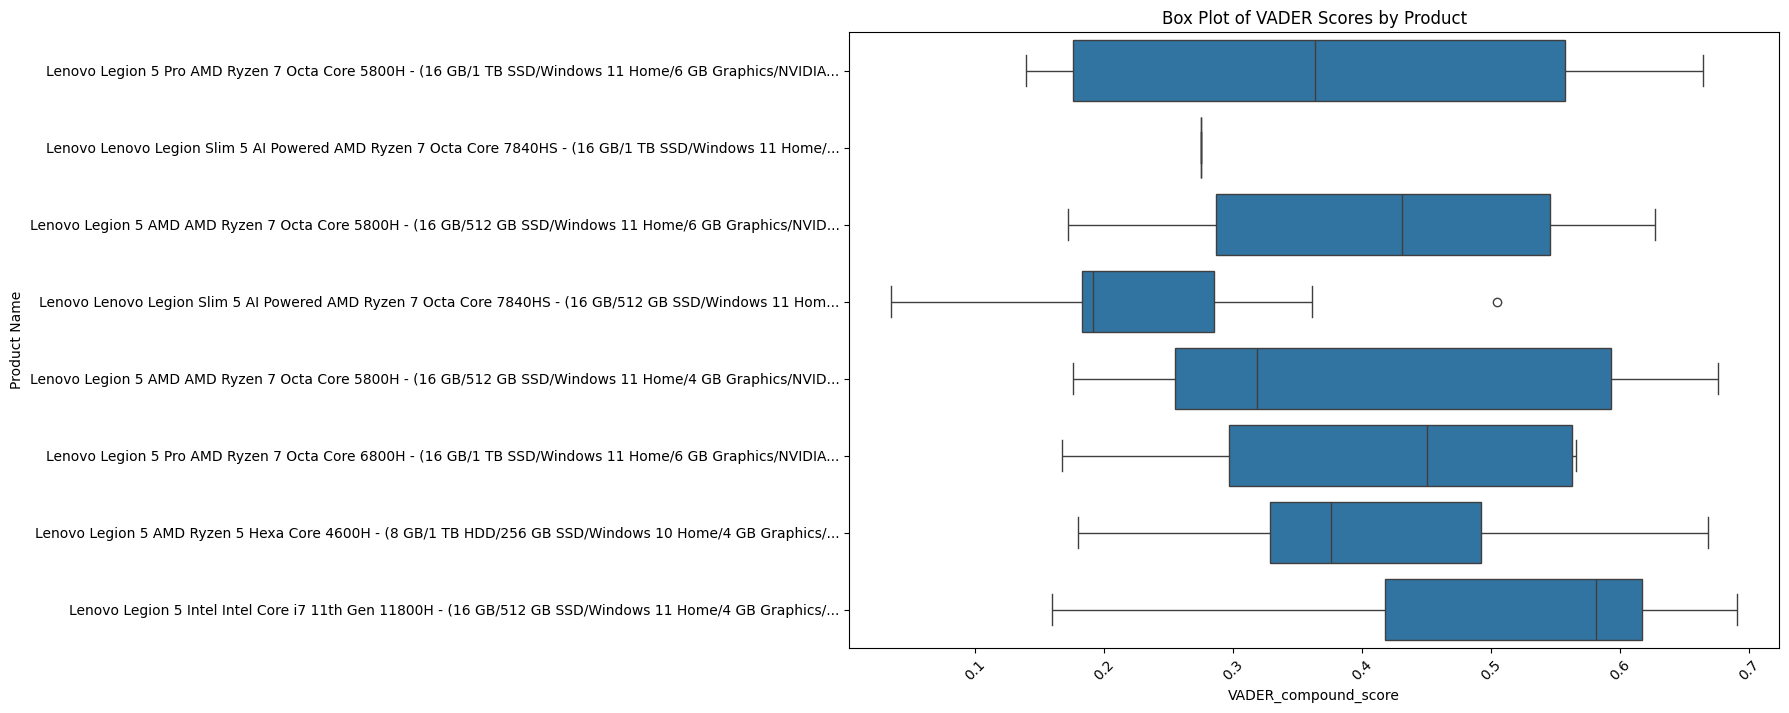

In [39]:
#Box Plot of VADER compound scores
plt.figure(figsize=(12, 8))  
sns.boxplot(x='VADER_compound_score', y='Product Name', data=df)  
plt.title('Box Plot of VADER Scores by Product')
plt.xticks(rotation=45)
plt.show()

## ROBERTA Sentiment Analysis

In [41]:
from transformers import RobertaConfig, RobertaModel

In [52]:
pip install torch

Note: you may need to restart the kernel to use updated packages.Collecting torch
  Using cached torch-2.3.0-cp312-cp312-win_amd64.whl.metadata (26 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
  Using cached MarkupSafe-2.1.5-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/159.7 MB 279.3 kB/s eta 0:09:32
   --

ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\suchi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\Users\suchi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\suchi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\suchi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\suchi\AppData\Local\Programs\Python\Python312\Lib\http\client.py", line 479, in read
    s = self.fp.read

   ------ -------------------------------- 28.7/159.7 MB 194.3 kB/s eta 0:11:15
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 194.0 kB/s eta 0:11:16
   ------- ------------------------------- 28.7/159.7 MB 192.9 kB/s eta 0:11:20
   ------- ------------------------------- 28.7/159.7 MB 192.9 kB/s eta 0:11:20
   ------- ------------------------------- 28.7/159.7 MB 192.9 kB/s eta 0:11:20
   ------- -----------------------------

In [53]:
#Loading the RoBERTa model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [47]:
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

SyntaxError: invalid syntax (775891298.py, line 1)